<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Pipeline on PDFs with Limited GPU Requirements

In this project, we aim to build a **Retrieval-Augmented Generation (RAG)** pipeline optimized for **limited GPU environments**. The goal is to combine the power of *dense retrieval-based methods* with the flexibility of generative models, while ensuring the system remains efficient enough to run on medium-tier laptops with GPUs.

A RAG pipeline consists of two main stages: **retrieval** and **generation**. The entire process can be divided into **3 key steps**:

1. **Generation of document embeddings**  
   In this step, document embeddings are generated from a *corpus* using an embedding model. Each document is encoded into a dense vector representation, capturing semantic information.

2. **Document retrieval**  
   Relevant documents are fetched from the corpus based on the input query. This is achieved by utilizing the generated embeddings and calculating similarity with the query's embedding to retrieve the most relevant documents.

3. **Output generation**  
   The retrieved documents are then passed to a **generative model**, which produces contextually relevant responses based on the information extracted from the documents.

By leveraging lightweight models and optimizing for efficiency, this RAG pipeline delivers powerful **AI-driven results** even on hardware with **limited resources**.

Finally, a **Gradio interface** is provided, allowing users to interact with the system and "chat" with the documents they provide, offering a seamless experience for exploring the content.

In [1]:
#%pip install -q --progress-bar torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes seaborn

In [2]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random

## Hardware requirements and constraints

Let's find out what hardware we've got available to see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [3]:
# Get GPU available memory
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")
print(torch.cuda.get_device_name(0))

Available GPU memory: 8 GB
NVIDIA GeForce RTX 3070 Laptop GPU


Of course, depending on the provided harware, better models can be utilized.

### Checking local GPU memory availability

Let's first analyze how we decided the model to use for this project. This notebook was primarily run and tested locally on a **laptop** with 16GB of RAM and an NVIDIA RTX 3070 laptop GPU (8GB of VRAM). The main goal was to create a pipeline that could efficiently run on this portable device, leveraging the benefits of GPUs and CUDA for AI tasks while ensuring that the performance and capabilities did not feel lacking compared to larger models.

We will need two main ingredients:
- An *embedder* model, that calculates dense embeddings from documents
- An *LLM*, that provides output given user's queries and the retrieved documents

In their dedicated sections we will uncover the choiches made for both.

### Load our PDF and start producing chunks

Let's now start by loading a pdf file and extracting chunks from it. These chunks' **quality** is important, since these will be essentially the *documents* on which we will compute the embeddings on.

In [4]:
PDF_NAME = "IR Slides v1.0.pdf"
running_on_colab = False

try:
    import gdown
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
login(token=HF_TOKEN)

Not running in Google Colab. Using load_dotenv to get HF_TOKEN.


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
def preprocess_text(text):
    # Rimuovi formule matematiche LaTeX
    text = re.sub(r'\$.*?\$', '', text)
    # Rimuovi caratteri non alfanumerici eccetto punteggiatura di base
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"-]', '', text)
    # Rimuovi •
    text = text.replace('•', '')
    # Normalizza i caratteri Unicode
    text = unidecode(text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggregate_short_documents(texts, min_length=50):
    aggregated_texts = []
    buffer = ""

    for doc in texts:
        if len(doc.page_content) < min_length:
            buffer += " " + doc.page_content
            buffer = buffer.strip()
        else:
            if buffer:
                doc.page_content = buffer + " " + doc.page_content
                buffer = ""
            aggregated_texts.append(doc)

    if buffer:
        if aggregated_texts:
            aggregated_texts[-1].page_content += " " + buffer
        else:
            aggregated_texts.append(buffer)

    return aggregated_texts

# ------------------------------------------------------------------------- #

# Load and process the PDF
loader = PyMuPDFLoader(file_path=file_path)
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separator="\n")
texts = text_splitter.split_documents(documents)

# Preprocess the text
for doc in texts:
    doc.page_content = preprocess_text(doc.page_content)

# Aggrega i documenti corti
corpus = aggregate_short_documents(texts)

Let's give a look to some random documents extracted and preprocessed from the initial pdf 

In [107]:
# print some random pages with their indices
random.seed(42)
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    print(f"DocId: {doc_index}, {doc.page_content[:100]}...")

DocId: 57, Ranked Retrieval In Boolean retrieval documents either match or dont a query Good for expert users w...
<class 'langchain_core.documents.base.Document'>
DocId: 12, cat command: reads files sequentially, writing them to the standard output tr command: copies the st...
<class 'langchain_core.documents.base.Document'>
DocId: 140, Given the sample space , the function is called probability. For each event , we denote as the proba...
<class 'langchain_core.documents.base.Document'>
DocId: 125, Example Assume relevant documents in total Assume an impatient user, i.e., RB 8 b 2 DCG10 3 1 log2 3...
<class 'langchain_core.documents.base.Document'>
DocId: 114, Rank-based Metrics Precision at document cutoff : where is the relevance judgment of the -th retriev...
<class 'langchain_core.documents.base.Document'>


In [7]:
print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")

Average document length: 464.3265993265993


We also provide a `save_documents` function, which can be useful for further inspection of the PDF content.

In [8]:
import os

def save_documents(documents):
    """
    Save the provided documents to the vector_store directory. Each document is saved as a separate text file.
    """
    if not os.path.exists("vector_store"):
        os.makedirs("vector_store")
    # delete all files in the vector_store directory
    for file in os.listdir("vector_store"):
        os.remove(os.path.join("vector_store", file))
    for i, doc in enumerate(documents):
        with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
            f.write(doc.page_content)

In [9]:
save_documents(corpus)
print(f"Saved {len(corpus)} documents in the vector_store directory.")

Saved 297 documents in the vector_store directory.


In [10]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", "").strip(),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


file_path = "quiz/quiz.json"

if running_on_colab:
  if not os.path.exists("quiz"):
      os.makedirs("quiz")
  # save locally from https://drive.google.com/file/d/15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__/view?usp=drive_link
  gdown.download(id="15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__", output=file_path, quiet=False)

queries = extract_questions(file_path)
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Loaded 60 questions.
{'question': 'Which of the following metrics is used to measure overlap between two sets?'}


## Gather Dataset Embeddings

In this first stage, the aim is to produce the documents embeddings, in order to be able to make similarity searches in the upcoming steps of the pipeline.

### About the `cde-small-v1` Model

The `cde-small-v1` model, developed by John X. Morris and Alexander M. Rush, is a cutting-edge model for generating **Contextual Document Embeddings (CDE)** ([link](https://huggingface.co/jxm/cde-small-v1)). What sets this model apart is its ability to integrate "*context tokens*" into the embedding process, which allows it to capture the nuances and relationships between documents more effectively. This makes it particularly suitable for generating highly accurate embeddings for both documents and queries, especially in cases where capturing the context of a document within the broader corpus is crucial.

We chose this model because, as of December 2024, it is one of the leading models under 400M parameters, delivering impressive results on the [**Massive Text Embedding Benchmark (MTEB) leaderboard**](https://huggingface.co/spaces/mteb/leaderboard). Although it ranks 32nd overall, it stands out as the top model in terms of **memory efficiency**, which is a key factor for our project, given the requirement for **limited GPU capabilities**. Additionally, it offers a substantial **embedding dimension of 768**, striking a balance between computational efficiency and embedding quality.

<style>
    img {
        border-radius: 15px;
    }
</style>
![cde-small-v1.png](./assets/cde-small-v1.png)

A key feature of the `cde-small-v1` model is its optimization for a two-stage embedding process:

1. **First Stage**: Embedding a subset of documents from the corpus to create "dataset embeddings," which serve as a **reference** for the entire corpus.
2. **Second Stage**: Using the dataset embeddings to embed new queries and documents during inference.

This model is compact yet delivers solid performance, making it suitable for our use case.

### Steps to Gather Dataset Embeddings:

1. **Selecting a Subset of Documents**  
   We begin by sampling a representative set of documents from the corpus. Following the model's guidelines, we select 512 documents. If this number isn't available, the model can handle oversampling, which is the case for the PDF dataset we're using. Despite this, performance remains strong.

2. **Generating Dataset Embeddings**  
   After selecting the documents, we encode them using the `cde-small-v1` embedding model. This step produces dense vector representations of the documents, which are representative of the broader corpus.

3. **Embedding Queries and Documents**  
   Once the dataset embeddings are created, we use them to embed both documents and queries. A key feature of this model is its ability to differentiate between 'queries' and 'documents' during encoding, ensuring context is preserved during the embedding process.


Next, we will load the model using the `SentenceTransformers` interface to begin the embedding process.

In [55]:
from sentence_transformers import SentenceTransformer

# with sentence-transformers we don't need prefixes but, to do retrieval, we need to use prompt_name="query" and prompt_name="document" in the encode method of the model when embedding queries and documents, respectively.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
).to(device)

Using device: cuda


C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\40b98394640e630d5276807046089b233113aa87\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


During the development of this project, the creators of the embedding model introduced a change in the Hugging Face repository that led to unstable results when using the `SentenceTransformer` implementation. If a similar issue occurs in the future, it can be mitigated by specifying the `revision` and `tokenizer_kwargs` parameters in the model constructor. These parameters allow you to lock the model and tokenizer to a specific branch name, tag, or commit ID from the Hugging Face repository.

Here’s an example of how to implement this:

```python
embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
    revision="9e2ed1d8d569d34458913d2d246935c1b2324d11",  # latest stable model revision
    tokenizer_kwargs={"revision": "86b5e0934494bd15c9632b12f734a8a67f723594"}  # latest stable tokenizer revision
).to(device)
```

The tags provided in the example above correspond to the latest stable commits (as of December 2024). You can retrieve these tags or commit IDs directly from the model's card page on Hugging Face, under the "Files and Versions" tab.

Then let's follow up by producing the `minicorpus` (which is the subsample of the whole corpus) and what we called `dataset_embeddings`

In [12]:
minicorpus_size = embeddings_model[0].config.transductive_corpus_size # 512
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # We must use exactly this many documents in the minicorpus

dataset_embeddings = embeddings_model.encode(
    [doc.page_content for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Corpus size: 297
Computed embeddings for 512 documents. Shape: torch.Size([512, 768])


In [13]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    print(f"document {i}: {minicorpus_docs[i].page_content[:100]}...")

Some mini-corpus documents:
document 425: Term Distribution Also known as distributed global indexing Single index is built for the whole clus...
document 134: Link Analysis Link-based ranking: use hyperlinks to rank web documents Use link counts as simple mea...
document 29: Cascading Query Index Processing 1,000 10,000 docs Base Ranker Inverted Index First Stage Top Ranker...
document 399: Multimedia Information Retrieval and Computer Vision nicola.tonellottounipi.it...
document 388: description lang"so"Hel wargelinada sunta cayayaanka ee cuntada ilmaha.description description lang"...


Now that we have obtained the **dataset embeddings**, we can proceed to embed both documents and queries using the same model.

To embed the documents and queries, we must ensure that we specify the correct `prompt_name` for each, as well as pass the `dataset_embeddings` to maintain context. The reason is that, as many state-of-the-art-models, this one was trained with task-specific prefixes:

- For documents, use:  
  `prompt_name="document"`

- For queries, use:  
  `prompt_name="query"`

We also have to always additionally, specify  the `dataset_embeddings`, in order to use the once we produced before.

By doing so, we ensure that the embeddings are generated with the correct context for both retrieval and generation tasks, leveraging the efficient performance of the `cde-small-v1` model.

In [15]:
doc_embeddings = embeddings_model.encode(
    [doc.page_content for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

query_embeddings = embeddings_model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([297, 768])
Query embeddings shape: torch.Size([60, 768])


We can now computes similarities between the embeddings and all the queries by simply calling `embeddings_model.similarity` (which uses by default cosine similarity), and inspect some of the results obtained.

In [16]:
similarities = embeddings_model.similarity(query_embeddings, doc_embeddings)
print("'similarities' shape : ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
    print()

'similarities' shape :  torch.Size([60, 297])
Query: Which of the following metrics is used to measure overlap between two sets?
Rank 1 (Score: 0.6110, Doc ID: 73): Jaccard Coefficient A common measure of overlap of two finite sets and : Always assigns a number between 0 and 1 and do not have to be the same size Note that and if What is the query-document match s...
Rank 2 (Score: 0.5788, Doc ID: 135): The -test assumes that the evaluation data is measure on an interval scale Differences between values are significant Effectiveness measures are an ordinal scale Differences between values are not sig...
Rank 3 (Score: 0.5662, Doc ID: 288): AB Testing Concept is fairly trivial: randomly split traffic between two or more versions A Control B Treatment Collect metrics of interest analyse Run statistical tests to confirm differences are not...
Rank 4 (Score: 0.5491, Doc ID: 113): Precision and recall are two different numbers to evaluate the effectiveness of an IR system Can we coalesce the

## Chroma

While not strictly necessary for this project - since the provided PDF is relatively small - we decided to integrate a vector database to enhance the storage and retrieval of the embeddings produced. This integration becomes particularly valuable when larger files are processed, as they often require splitting the corpus into smaller chunks, with each chunk generating its own embedding. The resulting large number of embeddings makes efficient storage and retrieval mechanisms increasingly important.

After evaluating various options, we selected [**Chroma**](https://www.trychroma.com/) for its simplicity of local deployment and good performances. Chroma is particularly well-suited for managing **large document collections**, providing **faster retrieval** and ensuring that the pipeline remains robust and adaptable to big files.

### Implementation Steps

We begin by creating a Chroma client and verifying if a collection named `'chroma-collection'` already exists locally:  if it does, we delete it to ensure a clean state before initializing a new one.

For reference, a Chroma client can be instantiated in two ways : 

- in an **ephemeral way** (in-memory), particularly useful for experimentation, such as testing different embedding functions and retrieval techniques. If data persistence is not a requirement, this approach provides a lightweight and efficient way to get started with Chroma while maintaining flexibility for quick iterations. This can be achieved with the following code:

    ```python
    import chromadb
    client = chromadb.Client()
    ```

- with a **persistent client**. This can be done by providing a  path where Chroma will store its database files on disk, and load them on start.

    ```python
    import chromadb
    client = chromadb.PersistentClient(path="/path/to/save/to")
    ```
    If a `path` is not provided, the default is `.chroma`

More about Chroma can be found in its [documentation](https://docs.trychroma.com/docs/overview/introduction). We choose to utilize the **persistent** approach, so let's follow by instantiating a `PersistentClient`;  if the collection already exists, we delete it to ensure a clean state before initializing a new one.


In [126]:
from chromadb import PersistentClient, Collection

COLLECTION_NAME = "chroma-collection"

# Initialize the Chroma client
client = PersistentClient(path="./"+COLLECTION_NAME)

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

Collection chroma-collection exists, deleting it


### Integration of `cde-small-v1` with Chroma

Integrating the **`cde-small-v1`** embedding model with Chroma required the creation of a custom `EmbeddingFunction`. This was necessary because **`cde-small-v1`** has a distinct workflow that deviates from standard embedding models. Specifically, as said it uses:

- **`prompt_name`**: This parameter distinguishes between "document" and "query" embeddings, to have proper alignment during retrieval tasks.
- **`dataset_embeddings`**: These provide a reference for conditional embedding generation, improving contextual accuracy in embeddings.

By default, Chroma does not natively support these additional parameters. However, it offers the flexibility of extending the `EmbeddingFunction` protocol, allowing us to integrate the specific requirements of the **`cde-small-v1`** model into Chroma’s workflow.

We can check the type of the elements of the corpus produced by our chunking functions and use it to differentiate between queries and documents.

In [127]:
print(type(corpus[0]))

<class 'langchain_core.documents.base.Document'>


In [128]:
from chromadb import Documents, EmbeddingFunction, Embeddings
import langchain_core

class CustomEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        """
        Automatically detect if the input is a document or a query and set the mode accordingly.
        :param input: Documents or queries to embed.
        :return: Embeddings.
        """
        # Detect the mode: "document" if the input is a list of documents, else "query".
        mode = "document" if isinstance(input[0], langchain_core.documents.base.Document) else "query"
    
        # If the input is a list of Documents, extract the text.
        if isinstance(input, list):
            input = [doc if isinstance(doc, str) else doc.page_content for doc in input]

        # Generate embeddings using the model with the determined mode
        embeddings = embeddings_model.encode(
            input,
            prompt_name=mode,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
            show_progress_bar=True
        ).cpu().numpy()

        return embeddings.tolist()

# Create an instance of the embeddings function for queries (we already calculated all the embeddings of the documents)
custom_embedding_function = CustomEmbeddingFunction()

Furthermore, while Chroma defaults to using Euclidean distance (`l2`) for nearest-neighbor search, the **`cde-small-v1`** embeddings from `SentenceTransformers` are based on cosine similarity by default. To utilize it, We configure the metadata parameter `"hnsw:space": "cosine"` when creating the collection. This ensures that Chroma uses cosine similarity, aligning with the previous behavior.

<style>
    img {
        border-radius: 15px;
    }
</style>
![chroma-similarity-measures.png](./assets/chroma-similarity-measures.png)

Once the collection is configured, we add all the documents and their precomputed embeddings to it.

> **NOTE:** We manually computed the embeddings beforehand (for analysis purposes) in the previous steps. If we had only provided the documents, Chroma would have automatically generated the embeddings using the `CustomEmbeddingFunction`, without the need for precomputation.

In [129]:
# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=custom_embedding_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents and their (already computed) embeddings to the collection
collection.add(
    ids=[str(i) for i in range(len(corpus))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    documents=[doc.page_content for doc in corpus],
)

In [133]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print("Number of documents in the corpus: ",len(corpus))
print("Number of documents in the collection: ",collection.count()) # returns the number of items in the collection

Number of documents in the corpus:  297
Number of documents in the collection:  297


We can finally test `collection.query` to make some calls to the Chroma collection, and we expect similar (ideally, the same) results as above, when we used `model.similarity`.

In [131]:
query_text = "How many bytes can UTF-8 use to encode a character?"

# create a Document object with the query text
results = collection.query(
    query_texts=query_text,
    n_results=5
)
print(results)

# Print the results with the document IDs and scores
for i, (doc_id, score, doc) in enumerate(zip(results['ids'][0], results['distances'][0], results['documents'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score:.4f}, {doc[:200]}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'ids': [['4', '3', '1', '6', '5']], 'embeddings': None, 'documents': [["All Unicode characters larger than U007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set This means that no ASCII byte can appear as part of any other character, because ASCII characters are the only characters whose leading bit is 0 The first byte of a multibyte sequence that represents a non-ASCII character is always in the range 0xC0 to 0xFD and it indicates how many bytes follow for this character One of 110xxxxx, 1110xxxx, 11110xxx, 111110xx, and 1111110x, where the x's may be 0's or 1's. The number of 1-bits following the first 1-bit up until the next 0-bit is the number of bytes in the rest of the sequence. All further bytes in a multibyte sequence start with the two bits 10 and are in the range 0x80 to 0xBF UTF-8 sequences must be of the following forms in binary, where the x's represent the bits from the code point, with the leftmost x-bit being its most sign

... which is exactly identical to the previous ones.

One final thing to note is that in Chroma cosine similarity is calculated as `1 - cosim` ; this is done to ensure that lower values indicate a better position in the ranked list. To obtain results consistent with the previous ones, we subtractde the score from one in the above code.


### Compute scores between queries and documents

Now we can analyze a similarity heatmap between the embeddings of our documents and the provided queries. The results show consistency with the following observations:

- **Few documents match the queries**: This suggests that the matching documents are likely the most relevant ones.
- **Matches often occur in subsequent documents**: This is expected since the corpus was split into chunks based on the document's structure. For example, chapters are separated, so answers to specific questions are more likely to be located within the same chapter or adjacent sections of the document.

Additionally, we provide a distribution of the similarity scores. This helps us assess whether an empirical threshold can be established to determine which documents are truly similar to the provided queries.

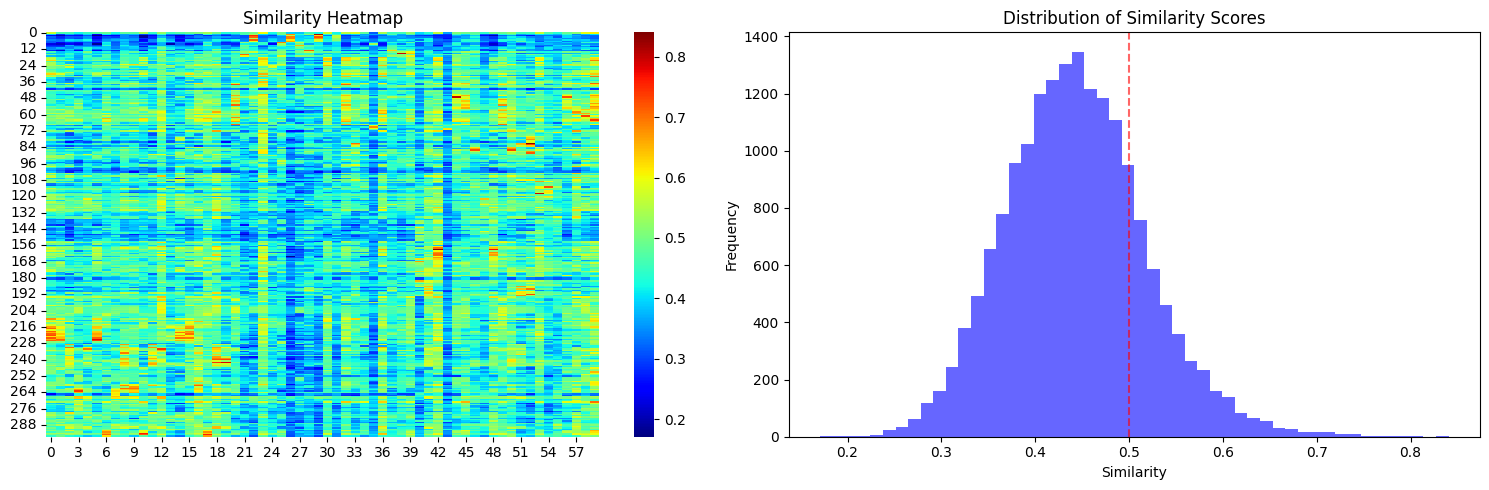

In [134]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()

## LLM

After conducting some research, we chose to work with one of Meta's latest smaller open-source Llama models available at the time of writing this notebook: [Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), released the *25th of September 2024*. We specifically selected the *instruct* variant because it is pre-trained to follow basic instructions, offering a more user-friendly and fine-tuned experience compared to the standard non-instruct version (which is also available). Below, we review this model's [specifications](https://llamaimodel.com/requirements-3-2/):

| **Llama 3.2 3B Instruct Model Specifications**                    | **Requirement**       | **Details**                                                                                  |
|----------------------------------|-----------------------|----------------------------------------------------------------------------------------------|
| Parameters                       | 3 billion             |                                                                                              |
| Context Length                   | 128,000 tokens        |                                                                                              |
| **Hardware Requirements**        |                       |                                                                                              |
| CPU and RAM                      |                       | CPU: Multicore processor <br> RAM: Minimum of 16 GB recommended                              |
| GPU                              |                       | NVIDIA RTX series (for optimal performance), at least 8 GB VRAM                              |
| **Estimated GPU Memory Requirements** |                       |                                                                                              |
| Higher Precision Modes           | BF16/FP16             | ~6.5 GB                                                                                      |
| Lower Precision Modes            | FP8                   | ~3.2 GB                                                                                      |
|                                  | INT4                  | ~1.75 GB                                                                                     |
| **Software Requirements**        |                       |                                                                                              |
| Software Dependencies            |                       | Frameworks: PyTorch <br> Libraries: Hugging Face Transformers (version 4.45.0 or higher), CUDA |

In [23]:
print("Is bf16 supported: ",torch.cuda.is_bf16_supported())

Is bf16 supported:  True


The `bitsandbytes` library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 & 4-bit quantization functions.

The library includes quantization primitives for 8-bit & 4-bit operations, through `bitsandbytes.nn.Linear8bitLt` and `bitsandbytes.nn.Linear4bit` and 8-bit optimizers through bitsandbytes.optim module.

#### Quantization Choices

We chose a *middle ground* by loading the model with **4-bit quantization** while maintaining **BFloat16** precision for computation.

The use of 4-bit quantization reduces the precision of the model’s weights to just 4 bits per value, significantly lowering memory usage and accelerating inference. This method retains only the most essential information, sacrificing some numerical precision, but allows for larger models to be handled on GPUs with limited memory. Despite the weights being quantized to 4 bits, the model still performs computations in **16-bit floating point (BFloat16)** precision. BFloat16 is a 16-bit format that preserves much of the dynamic range of floating-point operations while requiring less memory than the traditional 32-bit format. This way, while the 4-bit quantization reduces the memory footprint of the model weights, the computation is performed in BFloat16, optimizing performance on modern GPUs that are tailored for BFloat16 operations. This configuration strikes a balance between computational efficiency and numerical precision, enabling fast inferences with minimal memory usage without significant loss in result quality.

Given the hardware constraints, we opted for **4-bit quantization** using `BitsAndBytes` (as explained later). This approach greatly reduces the memory footprint and speeds up inference, ensuring acceptable performance for our use case. Without this configuration, the GPU’s memory usage was consistently at 100%, and inference times were approximately 2-3 minutes per query. With 4-bit quantization, memory usage drops to about 6GB, preventing GPU overload and reducing inference time to around 30 seconds per query, delivering satisfactory results. Further details on the quantization process will be provided later.

However, we also need to consider that both the embedding model and the LLM must be loaded into memory, which adds another layer of complexity to the memory management. This requires careful balancing, as the total memory usage must accommodate both the LLM and the embedding model simultaneously. We will address how we manage this in the next section.

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # TODO : riguardare che fa

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Quantization is a technique that reduces the precision of
# the model’s weights to make it run faster and consume less memory,
# often at the cost of a slight reduction in model accuracy or quality
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Lower precision reduces memory usage and can speed up inference (maybe try 8)
    bnb_4bit_use_double_quant=True,         # Using double quantization can help reduce the loss in accuracy associated with quantization
    bnb_4bit_quant_type="nf4",              # Normal Float 4-bit quantization, a scheme that may preserve model quality better than straightforward quantization methods
    bnb_4bit_compute_dtype=torch.bfloat16,  # The internal compute dtype used during inference. bfloat16 (BF16) is often chosen because it’s efficient on modern accelerators
    llm_int8_enable_fp32_cpu_offload=True   # Enable FP32 CPU offload
)


llm_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map={"": device},  # Custom device map to ensure all modules are on GPU
    quantization_config=bnb_config,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = llm_model.generation_config
generation_config.max_new_tokens = 200                    # the maximum number of new tokens the model will generate (long outputs might be more prone to off-topic or repetitive content)
generation_config.min_new_tokens = 1                      # the minimum number of new tokens the model will generate
generation_config.temperature = 0.1                       # it controls the randomness of the generation, lower temp means more deterministic, conservative (less creative) and repetitive answers [about 0.1-1.2]
generation_config.top_p = 0.5                             # nucleus sampling controls how the model picks words based on their cumulative probability, lower value (0.5) means safer, more coherent text but less diverse [about 0.5-0.9]
generation_config.num_return_sequences = 1                # how many separate output sequences are returned for each generation prompt, get multiple different answers in one go, useful for picking the best response from several tries
generation_config.pad_token_id = tokenizer.eos_token_id   # special token IDs that represent padding and the end-of-sequence token. Generally, these are set to ensure the model knows when to stop and how to handle inputs of different lengths
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.repetition_penalty = 2.0                # discourages the model from repeating the same phrases or tokens over and over [about 1.0-2.0] (high value cause the model to avoid some tokens even if they are contextually appropriate)

In [ ]:
# Check GPU usage
gpu_memory_gb = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # in GB
memory_allocated_gb = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
print(f"Memory Allocated: {memory_allocated_gb:.2f} GB")
print(f"Total memory usage: {(memory_allocated_gb / gpu_memory_gb) * 100:.2f}%")

In [ ]:
def retrieve_relevant_documents(query, k=5):
    results = collection.query( # query the Chroma collection
        query_texts=query,
        n_results=k
    )
    return results['documents'][0], results['distances'][0]

# test the function
query = "How many bytes can UTF-8 use to encode a character?"
print(f"Query: {query}")
documents, distances = retrieve_relevant_documents(query)
for doc, distance in (zip(documents, distances)):
    print(f"(score: {1-distance:.4f}) {doc[:200]}")

In [24]:
base_prompt = """You are an AI assistant for RAG. Your task is to understand the user question, and provide an answer using the provided contexts.

Your answers are correct, high-quality, and written by a domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {user_query}

Contexts:
{chunks_information}

Answer:
"""

In [25]:
# Example usage of the RAG system with the PDF
def answer_questions(questions):
    count = 0
    error = 0
    results = {}

    current_time = time.strftime("%m%d-%H%M%S")

    pbar = tqdm(questions, total=len(questions), desc="Answering questions...", unit="question")
    for q in pbar:
        top_k_chunks = retrieve_relevant_documents(q['question'], k=5)
        retrieved_chunks = [chunk for chunk in top_k_chunks]
        prompt = base_prompt.format(user_query=q['question'], chunks_information="\n".join(retrieved_chunks))
        encoding = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            outputs = llm_model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
                num_beams=5,  # Use beam search for better results
                early_stopping=True,  # Stop early if all beams finish
            )

        # Exclude the prompt tokens from the generated output
        generated_tokens = outputs[0][len(encoding.input_ids[0]):]
        generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        match = re.search(r'\b[1-4]\b', generated_unpreprocessed_sequence)
        answer = match.group(0) if match else ""  # first number found or empty string

        with open(f"quiz/runs_basemodel/quiz_answers_{current_time}.txt", "a", encoding="utf-8") as f:
            f.write(f"Question: {q['question']}\nAnswer: {answer}\nCorrect answer:{q['correct']}\nGenerated unpreprocessed sequence: {generated_unpreprocessed_sequence}\n--------------------------------------------------------------------\n\n")

        results[q['question_id']] = answer

        if len(answer) != 1 or answer not in "1234":
            error += 1
        else:  # the format is correct, now check if the answer is correct
            if str(q['correct']) == answer:
                count += 1
        pbar.set_postfix(Corrects=f"{count}/{len(questions)}", Errors=error)

    print("-------------------------\tFINISHED RUN. Error count: ", error, "-------------------------")
    return results, count / len(questions) * 100

In [ ]:
def query_rag_model(user_query):
    documents, distances = retrieve_relevant_documents(user_query, k=5) # retrieve the top 5 most relevant documents
    print(f"Number of retrieved documents: {len(documents)}")    
    # Print the results
    for doc, distance in zip(documents, distances):
        print(f"(score: {1-distance:.4f}) {doc[:200]}")
    prompt = base_prompt.format(user_query=user_query, chunks_information="\n".join(documents))
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = llm_model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
            num_beams=5,
            early_stopping=True,
        )
    generated_tokens = outputs[0][len(encoding.input_ids[0]):]
    generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    print(f"Generated sequence: {generated_unpreprocessed_sequence}")
    return generated_unpreprocessed_sequence

iface = gr.Interface(
    fn=query_rag_model,
    inputs="text",
    outputs="text",
    title="RAG Model Query Interface",
    description="Ask questions to the RAG model and get answers based on the provided PDF context."
)

iface.launch()